# Historical D2+ SD Changes
We compare the changes in SPEAR ensemble distribution of D2+ SD, precipitation, and select temperature metrics  to the Livneh dataset changes across the historical period (1930-2011). We felt that only the D2+ SD changes were relavent for the main paper, although the remainder of the notebook output is discussed in the supplemental.

In [1]:
from imports import *

## Snow Anomalies

In [3]:
# livneh
# open dataset and extract region names
# livneh dataset generated by computing ZSWE across the historical period relative to the livneh itself
livneh = xr.open_dataset("/work/Julian.Schmitt/data/swei/livneh_winter_swei.nc")
regions_dict = {float(livneh.mask[i]): str(livneh.regions[i].values) for i in range(len(livneh.mask))}

def is_winter(month):
    return (month <=4) | (month >=10)
# get percent change for livneh by region 
def get_drought_change(ds, threshold):
    # select time slices and create boolian drought vs no drought
    winter = ds.sel(time=is_winter(ds['time.month']))
    early = (winter < threshold).sel(time=slice("1930", "1970"))
    late = (winter < threshold).sel(time=slice("1971", "2011"))
    p_change = {}
    for region in [13,14,15,16,17]:
        name = np.array(winter.sel(mask=region).regions) # region name
        # sum # of drought months by region - compare early vs late
        print(name)
        count_early = int(early.sel(mask=region).sum().swe)
        print(count_early)
        count_late = int(late.sel(mask=region).sum().swe)
        print(count_late)
        increase = (count_late / count_early -1)*100
        print(increase)
        p_change[" ".join(str(name).split(" ")[0:-1])] = increase
    return p_change

# example calculation of SD drought changes at D2+ severity for all regions
drought_change = get_drought_change(livneh, -1.3)

Upper Colorado Region
27
28
3.703703703703698
Lower Colorado Region
21
24
14.28571428571428
Great Basin Region
22
32
45.45454545454546
Pacific Northwest Region
31
14
-54.83870967741935
California Region
22
24
9.090909090909083


In [4]:
# examine distribution of SPEAR models snow

def get_drought_change(ds, threshold):
    # select time slices and create boolian drought vs no drought
    winter = ds.sel(time=is_winter(ds['time.month']))
    early = (winter < threshold).sel(time=slice("1930", "1970"))
    late = (winter < threshold).sel(time=slice("1971", "2011"))
    p_change = {}
    for region in [13,14,15,16,17]:
        name = regions_dict[region]#np.array(winter.sel(mask=region).mask) # region name
        # sum # of drought months by region - compare early vs late
        #print(name)
        count_early = int(early.sel(mask=region).sum().snow)
        #print(count_early)
        count_late = int(late.sel(mask=region).sum().snow)
        #print(count_late)
        increase = (count_late / count_early -1)*100
        #print(increase)
        p_change[" ".join(str(name).split(" ")[0:-1])] = increase
    return p_change

ens_files = glob("/work/Julian.Schmitt/data/swei/hist/monthly_ens_*.nc")
ar_dict = []
for file in ens_files:
    ds = xr.open_dataset(file)
    f_dict = get_drought_change(ds, -1.3)
    ar_dict.append(f_dict)
    
ens_drought_spread = {}
for k in ar_dict[1].keys():
    ens_drought_spread[k] = tuple(d[k] for d in ar_dict)

In [5]:
def remove_outliers(ar):
    """Removes outliers > 2 standard deviations from the mean"""
    mean, sd = np.mean(ar), np.std(ar)
    deviation = abs(ar - mean)
    outliers = deviation > 4 * sd
    return ar[~outliers]

## Plot Calculated Changes
Calculate D2+ SD changes for all ensemble members and livneh across each HUC2 region

Upper Colorado 53.0 [30. 77.] [-50. 236.] 4.0
Lower Colorado 26.0 [13. 40.] [-39. 107.] 14.0
Great Basin 48.0 [26. 70.] [-40. 225.] 45.0
Pacific Northwest 43.0 [16. 71.] [-68. 255.] -55.0
California 46.0 [25. 67.] [-34. 192.] 9.0


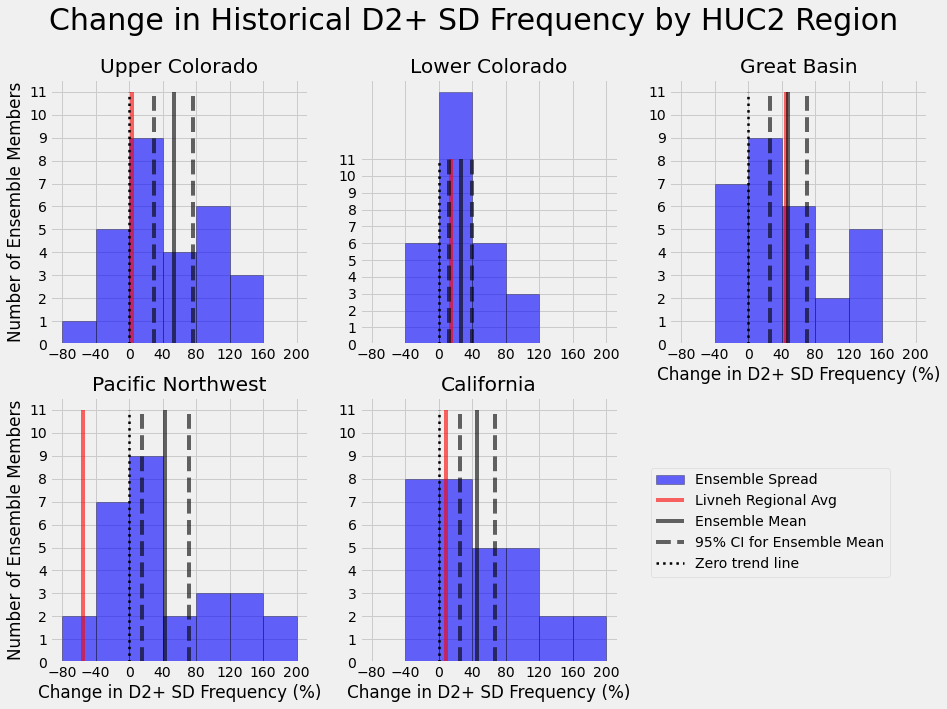

In [10]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(2,3, figsize=(14,10))
regions = list(ens_drought_spread.keys())
fax = ax.ravel()
bins = np.arange(-80, 240, 40)
handles, labels = None, None
for ind, k in enumerate(regions):
    # get ensemble data and plot histogram
    regions_ens_spread = remove_outliers(np.array(ens_drought_spread[k]))
    #print(len(regions_ens_spread))
    fax[ind].hist(regions_ens_spread, bins = bins, edgecolor='black', label="Ensemble Spread", color="blue", alpha=0.6)
    
    # ticks and titles
    fax[ind].set_xticks(bins)
    fax[ind].set_yticks(np.arange(0,12))
    fax[ind].set_title(regions[ind])
    if ind in [0,3]:
        fax[ind].set_ylabel("Number of Ensemble Members")
    if ind in [2,3,4]:
        fax[ind].set_xlabel("Change in D2+ SD Frequency (%)")
    
    # add line for livneh dataset and H&A average
    fax[ind].vlines(drought_change[k], ymin=0, ymax=11, color='red',alpha=0.6, label ="Livneh Regional Avg")
    #fax[ind].vlines(30, ymin=0, ymax=11, color='green', alpha=0.6, label="H&A West Overall Average")
    
    # plot vlines for ensemble 5th and 95th percentiles
    ens_mean, ens_std = np.mean(regions_ens_spread), np.std(regions_ens_spread)
    fax[ind].vlines(ens_mean, color='black', alpha=0.6, linewidth=4, ymin=0, ymax=11, label="Ensemble Mean")
    percentiles = [ens_mean - 1.96*ens_std/(np.sqrt(len(regions_ens_spread))), 
                  ens_mean + 1.96*ens_std/(np.sqrt(len(regions_ens_spread)))]
    min_max = [np.min(regions_ens_spread), np.max(regions_ens_spread)]
    print(k, np.round(ens_mean), np.round(percentiles), np.round(min_max),np.round(drought_change[k]))
    fax[ind].vlines(percentiles, color='black', alpha=0.6, 
                    linestyle="dashed", label="95% CI for Ensemble Mean", ymin=0, ymax=11, linewidth=4)
    
    # vertical line at zero for zero trend line
    fax[ind].vlines(0, color='black', label = "Zero trend line", ymin=0, ymax=11, linewidth=2.5, linestyle='dotted')
    
    # get handle labels for legend
    handles, labels = fax[ind].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.42, -0.15, 0.5, 0.5))#loc="lower right")
plt.suptitle("Change in Historical D2+ SD Frequency by HUC2 Region", fontsize=30)
plt.title("Change calculated over the early (1930-1970) to late (1970-2011) historical period")
fig.delaxes(ax[1,2])
plt.grid(True)
plt.savefig("/home/Julian.Schmitt/plots/historical_change_0.png", dpi=180)

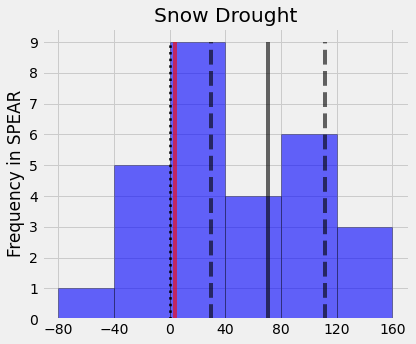

In [71]:
# single plot for UC
UC = ens_drought_spread[regions[0]]
bins = np.arange(-80, 200, 40)
plt.figure(figsize=(6,5))
plt.hist(UC, bins = bins, edgecolor='black', label="Ensemble Spread", color="blue", alpha=0.6)
ymax = 9
# ticks and titles
plt.xticks(bins)
plt.yticks(np.arange(0,12))
plt.title("Snow Drought")
plt.ylabel("Frequency in SPEAR")
#plt.xlabel("Percent Change in SD")
# add line for livneh dataset and H&A average
plt.vlines(drought_change[regions[0]], ymin=0, ymax=ymax, color='red',alpha=0.6, label ="Livneh Regional Avg")
#fax[ind].vlines(30, ymin=0, ymax=11, color='green', alpha=0.6, label="H&A West Overall Average")

# plot vlines for ensemble 5th and 95th percentiles
ens_mean, ens_std = np.mean(UC), np.std(UC)
plt.vlines(ens_mean, color='black', alpha=0.6, linewidth=4, ymin=0, ymax=ymax, label="Ensemble Mean")

percentiles = [ens_mean - 1.96*ens_std/(np.sqrt(len(regions_ens_spread))), 
              ens_mean + 1.96*ens_std/(np.sqrt(len(regions_ens_spread)))]
plt.vlines(percentiles, color='black', alpha=0.6, 
                linestyle="dashed", label="95% CI for Ensemble Mean", ymin=0, ymax=ymax, linewidth=4)

# vertical line at zero for zero trend line
plt.vlines(0, color='black', label = "Zero trend line", ymin=0, ymax=ymax, linewidth=2.5, linestyle='dotted')
plt.tight_layout()
plt.savefig("/home/Julian.Schmitt/plots/UC_SD.png", dpi=200)

## Precipitation Anomalies
We also look at changes in precipitation drought across 

In [2]:
# open dataset and extract region names
livneh = xr.open_dataset("/work/Julian.Schmitt/data/livneh/livneh_PRECI.nc")
regions_dict = {float(livneh.mask[i]): str(livneh.regions[i].values) for i in range(len(livneh.mask))}

In [3]:
def is_winter(month):
    return (month <=4) | (month >=10)
# get percent change for livneh by region 
def get_drought_change(ds, threshold):
    # select time slices and create boolian drought vs no drought
    winter = ds.sel(time=is_winter(ds['time.month']))
    early = (winter < threshold).sel(time=slice("1930", "1970"))
    late = (winter < threshold).sel(time=slice("1971", "2011"))
    p_change = {}
    for region in [13,14,15,16,17]:
        name = np.array(winter.sel(mask=region).regions) # region name
        # sum # of drought months by region - compare early vs late
        print(name)
        count_early = int(early.sel(mask=region).sum().prec)
        #print(count_early)
        count_late = int(late.sel(mask=region).sum().prec)
        #print(count_late)
        increase = (count_late / count_early -1)*100
        print(increase)
        p_change[" ".join(str(name).split(" ")[0:-1])] = increase
    return p_change
drought_change = get_drought_change(livneh, -1.3)

Upper Colorado Region
26.086956521739136
Lower Colorado Region
47.61904761904763
Great Basin Region
19.999999999999996
Pacific Northwest Region
-30.76923076923077
California Region
31.818181818181813


In [4]:
# examine distribution of SPEAR models precipitation

def get_drought_change(ds, threshold):
    # select time slices and create boolian drought vs no drought
    winter = ds.sel(time=is_winter(ds['time.month']))
    early = (winter < threshold).sel(time=slice("1930", "1970"))
    late = (winter < threshold).sel(time=slice("1971", "2011"))
    p_change = {}
    for region in [13,14,15,16,17]:
        name = regions_dict[region]#np.array(winter.sel(mask=region).mask) # region name
        # sum # of drought months by region - compare early vs late
        #print(name)
        count_early = int(early.sel(mask=region).sum().precip)
        #print(count_early)
        count_late = int(late.sel(mask=region).sum().precip)
        #print(count_late)
        increase = (count_late / count_early -1)*100
        #print(increase)
        p_change[" ".join(str(name).split(" ")[0:-1])] = increase
    return p_change

ens_files = glob("/work/Julian.Schmitt/data/precipi/hist/monthly_ens_*.nc")
ar_dict = []
for file in ens_files:
    ds = xr.open_dataset(file)
    f_dict = get_drought_change(ds, -1.3)
    ar_dict.append(f_dict)
    
ens_drought_spread = {}
for k in ar_dict[1].keys():
    ens_drought_spread[k] = tuple(d[k] for d in ar_dict)

Upper Colorado 2.0 [-6. 11.] [-55.  60.] 26.0
Lower Colorado 16.0 [ 5. 26.] [-21.  88.] 48.0
Great Basin 1.0 [-6.  8.] [-39.  45.] 20.0
Pacific Northwest 1.0 [-9. 11.] [-44.  88.] -31.0
California 3.0 [-7. 13.] [-49.  55.] 32.0


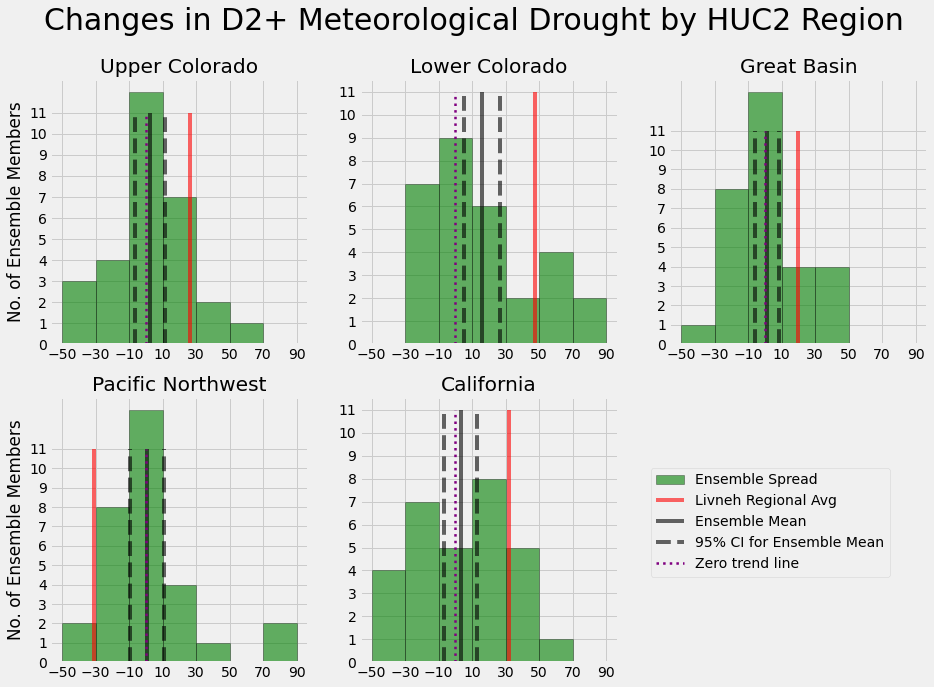

In [8]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(2,3, figsize=(14,10))
regions = list(ens_drought_spread.keys())
fax = ax.ravel()
bins = np.arange(-50,100, 20)
handles, labels = None, None
for ind, k in enumerate(regions):
    # get ensemble data and plot histogram
    regions_ens_spread = ens_drought_spread[k]
    fax[ind].hist(regions_ens_spread, bins = bins, edgecolor='black', label="Ensemble Spread", color="green", alpha=0.6)
    
    # ticks and titles
    fax[ind].set_xticks(np.arange(-50,100, 20))
    fax[ind].set_yticks(np.arange(0,12))
    fax[ind].set_title(regions[ind])
    if ind in [0,3]:
        fax[ind].set_ylabel("No. of Ensemble Members")
    
    # add line for livneh dataset and H&A average
    fax[ind].vlines(drought_change[k], ymin=0, ymax=11, color='red',alpha=0.6, label ="Livneh Regional Avg")
    #fax[ind].vlines(30, ymin=0, ymax=11, color='green', alpha=0.6, label="H&A West Overall Average")
    
    # plot vlines for ensemble 5th and 95th percentiles
    ens_mean, ens_std = np.mean(regions_ens_spread), np.std(regions_ens_spread)
    fax[ind].vlines(ens_mean, color='black', alpha=0.6, linewidth=4, ymin=0, ymax=11, label="Ensemble Mean")
    
    percentiles = [ens_mean - 1.96*ens_std/(np.sqrt(len(regions_ens_spread))), 
                  ens_mean + 1.96*ens_std/(np.sqrt(len(regions_ens_spread)))]
    fax[ind].vlines(percentiles, color='black', alpha=0.6, 
                    linestyle="dashed", label="95% CI for Ensemble Mean", ymin=0, ymax=11, linewidth=4)
    # zero trend line
    fax[ind].vlines(0, color='purple', label = "Zero trend line", ymin=0, ymax=11, linewidth=2.5, linestyle='dotted')

    percentiles = [ens_mean - 1.96*ens_std/(np.sqrt(len(regions_ens_spread))), 
                  ens_mean + 1.96*ens_std/(np.sqrt(len(regions_ens_spread)))]
    min_max = [np.min(regions_ens_spread), np.max(regions_ens_spread)]
    print(k, np.round(ens_mean), np.round(percentiles), np.round(min_max),np.round(drought_change[k]))

    
    # get handle labels for legend
    handles, labels = fax[ind].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.42, -0.15, 0.5, 0.5))#loc="lower right")
plt.suptitle("Changes in D2+ Meteorological Drought by HUC2 Region", fontsize=30)
fig.delaxes(ax[1,2])
plt.grid(True)
plt.savefig("/home/Julian.Schmitt/plots/PRECIP_D2_ensemble_percentiles.png", dpi=250)

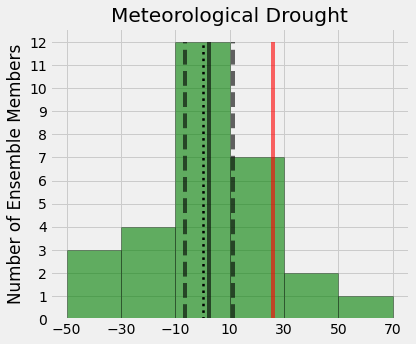

In [76]:
# single plot for UC
UC = ens_drought_spread[regions[0]]
bins = np.arange(-50, 80, 20)
plt.figure(figsize=(6,5))
plt.hist(UC, bins = bins, edgecolor='black', label="Ensemble Spread", color="green", alpha=0.6)
ymax = 12
# ticks and titles
plt.xticks(bins)
plt.yticks(np.arange(0,ymax+1))
plt.title("Meteorological Drought")
plt.ylabel("Number of Ensemble Members")
#plt.xlabel("Percent Change in Meteorological Drought")
# add line for livneh dataset and H&A average
plt.vlines(drought_change[regions[0]], ymin=0, ymax=ymax, color='red',alpha=0.6, label ="Livneh")
#fax[ind].vlines(30, ymin=0, ymax=11, color='green', alpha=0.6, label="H&A West Overall Average")

# plot vlines for ensemble 5th and 95th percentiles
ens_mean, ens_std = np.mean(UC), np.std(UC)
plt.vlines(ens_mean, color='black', alpha=0.6, linewidth=4, ymin=0, ymax=ymax, label="Ensemble Mean")

percentiles = [ens_mean - 1.96*ens_std/(np.sqrt(len(regions_ens_spread))), 
              ens_mean + 1.96*ens_std/(np.sqrt(len(regions_ens_spread)))]
plt.vlines(percentiles, color='black', alpha=0.6, 
                linestyle="dashed", label="95% CI", ymin=0, ymax=ymax, linewidth=4)

# vertical line at zero for zero trend line
plt.vlines(0, color='black', label = "Zero trend", ymin=0, ymax=ymax, linewidth=2.5, linestyle='dotted')
plt.tight_layout()
plt.savefig("/home/Julian.Schmitt/plots/UC_MD.png", dpi=200)

# Examine TMAX

In [20]:
# open dataset and extract region names
tmax = xr.open_dataset("/work/Julian.Schmitt/data/livneh/livneh_TMAXI.nc")
regions_dict = {float(tmax.mask[i]): str(tmax.regions[i].values) for i in range(len(tmax.mask))}

In [21]:
def is_winter(month):
    return (month <=4) | (month >=10)
# get percent change for livneh by region 
def get_drought_change(ds, threshold):
    # select time slices and create boolian drought vs no drought
    winter = ds.sel(time=is_winter(ds['time.month']))
    early = (winter > threshold).sel(time=slice("1930", "1970"))
    late = (winter > threshold).sel(time=slice("1971", "2011"))
    p_change = {}
    for region in [13,14,15,16,17]:
        name = regions_dict[region]#np.array(winter.sel(mask=region).regions) # region name
        # sum # of drought months by region - compare early vs late
        #print(name)
        count_early = int(early.sel(mask=region).sum().tmax)
        #print(count_early)
        count_late = int(late.sel(mask=region).sum().tmax)
        #print(count_late)
        increase = (count_late / count_early -1)*100
        #print(increase)
        p_change[" ".join(str(name).split(" ")[0:-1])] = increase
    return p_change
drought_change = get_drought_change(tmax, 1.3)

In [22]:
ens_files = glob("/work/Julian.Schmitt/data/tmaxi/monthly_ens_*.nc")
ar_dict = []
for file in ens_files:
    ds = xr.open_dataset(file)
    f_dict = get_drought_change(ds, 1.3)
    ar_dict.append(f_dict)
    
ens_drought_spread = {}
for k in ar_dict[1].keys():
    ens_drought_spread[k] = tuple(d[k] for d in ar_dict)

Upper Colorado 73.0 [56. 90.] [ -7. 193.] -12.0
Lower Colorado 65.0 [49. 81.] [-13. 153.] -21.0
Great Basin 59.0 [39. 79.] [-21. 207.] -7.0
Pacific Northwest 67.0 [44. 89.] [-10. 221.] -32.0
California 65.0 [46. 83.] [  0. 169.] 11.0


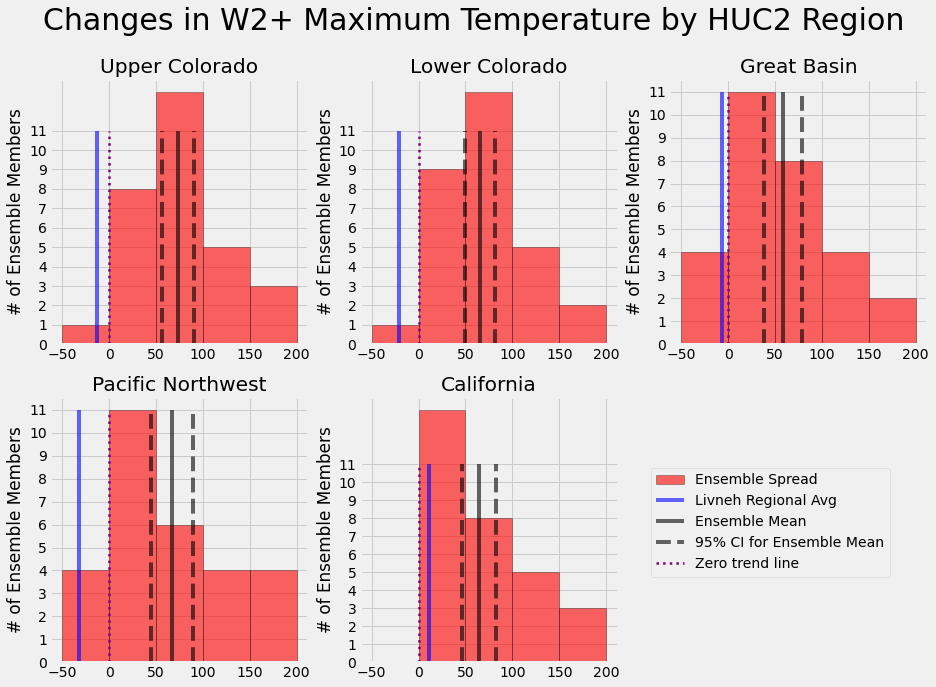

In [23]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(2,3, figsize=(14,10))
regions = list(ens_drought_spread.keys())
fax = ax.ravel()
bins = np.arange(-50,201, 50)
handles, labels = None, None
for ind, k in enumerate(regions):
    # get ensemble data and plot histogram
    regions_ens_spread = ens_drought_spread[k]
    fax[ind].hist(regions_ens_spread, bins = bins, edgecolor='black', label="Ensemble Spread", color="red", alpha=0.6)
    
    # ticks and titles
    fax[ind].set_xticks(bins)
    fax[ind].set_yticks(np.arange(0,12))
    fax[ind].set_title(regions[ind])
    fax[ind].set_ylabel("# of Ensemble Members")
    
    # add line for livneh dataset and H&A average
    fax[ind].vlines(drought_change[k], ymin=0, ymax=11, color='blue',alpha=0.6, label ="Livneh Regional Avg")
    #fax[ind].vlines(30, ymin=0, ymax=11, color='green', alpha=0.6, label="H&A West Overall Average")
    
    
    # plot vlines for ensemble 5th and 95th percentiles
    ens_mean, ens_std = np.mean(regions_ens_spread), np.std(regions_ens_spread)
    fax[ind].vlines(ens_mean, color='black', alpha=0.6, linewidth=4, ymin=0, ymax=11, label="Ensemble Mean")
    
    percentiles = [ens_mean - 1.96*ens_std/(np.sqrt(len(regions_ens_spread))), 
                  ens_mean + 1.96*ens_std/(np.sqrt(len(regions_ens_spread)))]
    fax[ind].vlines(percentiles, color='black', alpha=0.6, 
                    linestyle="dashed", label="95% CI for Ensemble Mean", ymin=0, ymax=11, linewidth=4)
    # zero trend line
    fax[ind].vlines(0, color='purple', label = "Zero trend line", ymin=0, ymax=11, 
                    linewidth=2.5, linestyle='dotted')
    percentiles = [ens_mean - 1.96*ens_std/(np.sqrt(len(regions_ens_spread))), 
                  ens_mean + 1.96*ens_std/(np.sqrt(len(regions_ens_spread)))]
    min_max = [np.min(regions_ens_spread), np.max(regions_ens_spread)]
    print(k, np.round(ens_mean), np.round(percentiles), np.round(min_max),np.round(drought_change[k]))
    
    # get handle labels for legend
    handles, labels = fax[ind].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.42, -0.15, 0.5, 0.5))#loc="lower right")
plt.suptitle("Changes in W2+ Maximum Temperature by HUC2 Region", fontsize=30)
fig.delaxes(ax[1,2])
plt.grid(True)
plt.savefig("/home/Julian.Schmitt/plots/TMAX_W2HOT_ensemble_percentiles.png", dpi=250)

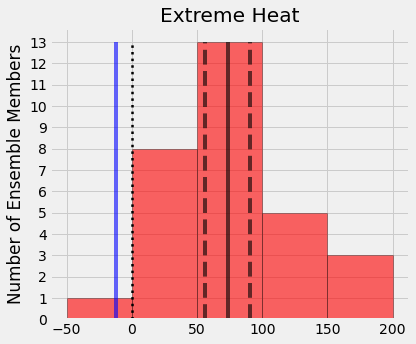

In [81]:
# single plot for UC
UC = ens_drought_spread[regions[0]]
bins = np.arange(-50,250, 50)
plt.figure(figsize=(6,5))
plt.hist(UC, bins = bins, edgecolor='black', label="Ensemble Spread", color="red", alpha=0.6)
ymax = 13
# ticks and titles
plt.xticks(bins)
plt.yticks(np.arange(0,ymax+1))
plt.title("Extreme Heat")
plt.ylabel("Number of Ensemble Members")
#plt.xlabel("Percent Change in Extreme Heat")
# add line for livneh dataset and H&A average
plt.vlines(drought_change[regions[0]], ymin=0, ymax=ymax, color='blue',alpha=0.6, label ="Livneh")
#fax[ind].vlines(30, ymin=0, ymax=11, color='green', alpha=0.6, label="H&A West Overall Average")

# plot vlines for ensemble 5th and 95th percentiles
ens_mean, ens_std = np.mean(UC), np.std(UC)
plt.vlines(ens_mean, color='black', alpha=0.6, linewidth=4, ymin=0, ymax=ymax, label="Ensemble Mean")

percentiles = [ens_mean - 1.96*ens_std/(np.sqrt(len(regions_ens_spread))), 
              ens_mean + 1.96*ens_std/(np.sqrt(len(regions_ens_spread)))]
plt.vlines(percentiles, color='black', alpha=0.6, 
                linestyle="dashed", label="95% CI", ymin=0, ymax=ymax, linewidth=4)

# vertical line at zero for zero trend line
plt.vlines(0, color='black', label = "Zero trend", ymin=0, ymax=ymax, linewidth=2.5, linestyle='dotted')
#plt.legend(bbox_to_anchor=(0.5,0.5,0.6,0.5))
plt.tight_layout()
plt.savefig("/home/Julian.Schmitt/plots/UC_Extreme_heat.png", dpi=200)

# Examine TMIN
First we look for changes in extreme cold - we should see a decrease 

In [24]:
# open dataset and extract region names
tmin = xr.open_dataset("/work/Julian.Schmitt/data/livneh/livneh_TMINI.nc")
regions_dict = {float(tmax.mask[i]): str(tmax.regions[i].values) for i in range(len(tmax.mask))}

In [25]:
def is_winter(month):
    return (month <=4) | (month >=10)
# get percent change for livneh by region 
def get_drought_change(ds, threshold):
    # select time slices and create boolian drought vs no drought
    winter = ds.sel(time=is_winter(ds['time.month']))
    early = (winter < threshold).sel(time=slice("1930", "1970"))
    late = (winter < threshold).sel(time=slice("1971", "2011"))
    p_change = {}
    for region in [13,14,15,16,17]:
        name = regions_dict[region]#np.array(winter.sel(mask=region).regions) # region name
        # sum # of drought months by region - compare early vs late
        #print(name)
        count_early = int(early.sel(mask=region).sum().tmin)
        #print(count_early)
        count_late = int(late.sel(mask=region).sum().tmin)
        #print(count_late)
        increase = (count_late / count_early -1)*100
        #print(increase)
        p_change[" ".join(str(name).split(" ")[0:-1])] = increase
    return p_change
drought_change = get_drought_change(tmin, -1.3)

In [26]:
ens_files = glob("/work/Julian.Schmitt/data/tmini/monthly_ens_*.nc")
ar_dict = []
for file in ens_files:
    ds = xr.open_dataset(file)
    f_dict = get_drought_change(ds, -1.3)
    ar_dict.append(f_dict)
    
ens_drought_spread = {}
for k in ar_dict[1].keys():
    ens_drought_spread[k] = tuple(d[k] for d in ar_dict)

Upper Colorado -20.0 [-29. -11.] [-58.  23.] -62.0
Lower Colorado -19.0 [-29. -10.] [-67.  53.] -75.0
Great Basin -18.0 [-28.  -7.] [-67.  55.] -33.0
Pacific Northwest -20.0 [-29. -11.] [-66.  43.] -45.0
California -21.0 [-29. -13.] [-57.  29.] -65.0


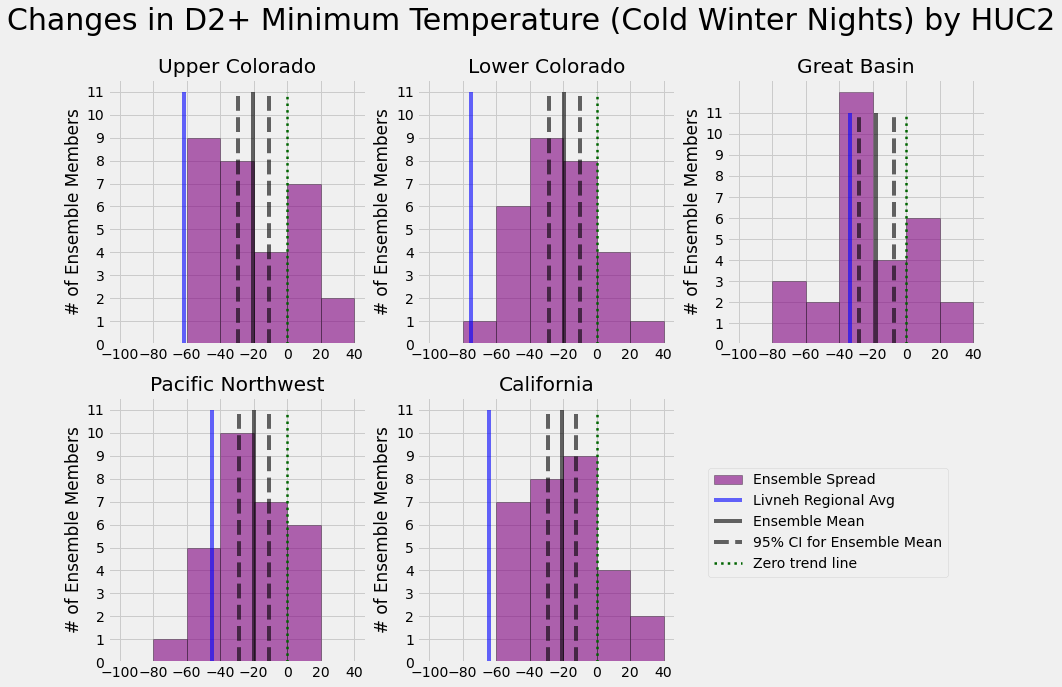

In [27]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(2,3, figsize=(14,10))
regions = list(ens_drought_spread.keys())
fax = ax.ravel()
bins = np.arange(-100,50, 20)
handles, labels = None, None
for ind, k in enumerate(regions):
    # get ensemble data and plot histogram
    regions_ens_spread = ens_drought_spread[k]
    fax[ind].hist(regions_ens_spread, bins = bins, edgecolor='black', label="Ensemble Spread", color="purple", alpha=0.6)
    
    # ticks and titles
    fax[ind].set_xticks(bins)
    fax[ind].set_yticks(np.arange(0,12))
    fax[ind].set_title(regions[ind])
    fax[ind].set_ylabel("# of Ensemble Members")
    
    # add line for livneh dataset and H&A average
    fax[ind].vlines(drought_change[k], ymin=0, ymax=11, color='blue',alpha=0.6, label =f"Livneh Regional Avg")
    
    # plot vlines for ensemble 5th and 95th percentiles
    ens_mean, ens_std = np.mean(regions_ens_spread), np.std(regions_ens_spread)
    fax[ind].vlines(ens_mean, color='black', alpha=0.6, linewidth=4, ymin=0, ymax=11, label="Ensemble Mean")
    
    percentiles = [ens_mean - 1.96*ens_std/(np.sqrt(len(regions_ens_spread))), 
                  ens_mean + 1.96*ens_std/(np.sqrt(len(regions_ens_spread)))]
    fax[ind].vlines(percentiles, color='black', alpha=0.6, 
                    linestyle="dashed", label="95% CI for Ensemble Mean", ymin=0, ymax=11, linewidth=4)
    # zero trend line
    fax[ind].vlines(0, color='darkgreen', label = "Zero trend line", ymin=0, ymax=11, 
                    linewidth=2.5, linestyle='dotted')

    percentiles = [ens_mean - 1.96*ens_std/(np.sqrt(len(regions_ens_spread))), 
                  ens_mean + 1.96*ens_std/(np.sqrt(len(regions_ens_spread)))]
    min_max = [np.min(regions_ens_spread), np.max(regions_ens_spread)]
    print(k, np.round(ens_mean), np.round(percentiles), np.round(min_max),np.round(drought_change[k]))


    
    # get handle labels for legend
    handles, labels = fax[ind].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.42, -0.15, 0.5, 0.5))#loc="lower right")
plt.suptitle("Changes in D2+ Minimum Temperature (Cold Winter Nights) by HUC2", fontsize=30)
fig.delaxes(ax[1,2])
plt.grid(True)
plt.savefig("/home/Julian.Schmitt/plots/TMIN_cold_winter_nights_ensemble_percentiles", dpi=250)

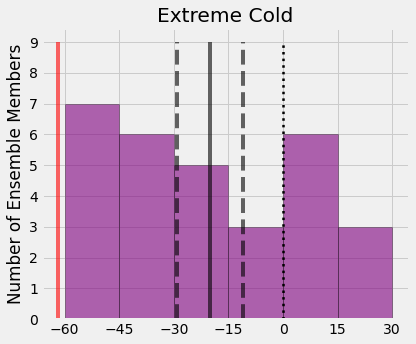

In [86]:
# single plot for UC
UC = ens_drought_spread[regions[0]]
bins = np.arange(-60,45, 15)
plt.figure(figsize=(6,5))
plt.hist(UC, bins = bins, edgecolor='black', label="Ensemble Spread", color="purple", alpha=0.6)
ymax = 9
# ticks and titles
plt.xticks(bins)
plt.yticks(np.arange(0,ymax+1))
plt.title("Extreme Cold")
plt.ylabel("Number of Ensemble Members")
#plt.xlabel("Percent Change in Extreme Cold")
# add line for livneh dataset and H&A average
plt.vlines(drought_change[regions[0]], ymin=0, ymax=ymax, color='red',alpha=0.6, label ="Livneh Regional Avg")
#fax[ind].vlines(30, ymin=0, ymax=11, color='green', alpha=0.6, label="H&A West Overall Average")

# plot vlines for ensemble 5th and 95th percentiles
ens_mean, ens_std = np.mean(UC), np.std(UC)
plt.vlines(ens_mean, color='black', alpha=0.6, linewidth=4, ymin=0, ymax=ymax, label="Ensemble Mean")

percentiles = [ens_mean - 1.96*ens_std/(np.sqrt(len(regions_ens_spread))), 
              ens_mean + 1.96*ens_std/(np.sqrt(len(regions_ens_spread)))]
plt.vlines(percentiles, color='black', alpha=0.6, 
                linestyle="dashed", label="95% CI for Ensemble Mean", ymin=0, ymax=ymax, linewidth=4)

# vertical line at zero for zero trend line
plt.vlines(0, color='black', label = "Zero trend line", ymin=0, ymax=ymax, linewidth=2.5, linestyle='dotted')
plt.tight_layout()
plt.savefig("/home/Julian.Schmitt/plots/UC_Extreme_cold.png", dpi=200)

# Changes in warm winter nights - should see increase
Above we saw that cold winter nights are decreasing, now we want to see if warm winter nights are increasing

In [28]:
# open dataset and extract region names
tmin = xr.open_dataset("/work/Julian.Schmitt/data/livneh/livneh_TMINI.nc")
regions_dict = {float(tmax.mask[i]): str(tmax.regions[i].values) for i in range(len(tmax.mask))}

In [29]:
def is_winter(month):
    return (month <=4) | (month >=10)
# get percent change for livneh by region 
def get_drought_change(ds, threshold):
    # select time slices and create boolian drought vs no drought
    winter = ds.sel(time=is_winter(ds['time.month']))
    early = (winter > threshold).sel(time=slice("1930", "1970"))
    late = (winter > threshold).sel(time=slice("1971", "2011"))
    p_change = {}
    for region in [13,14,15,16,17]:
        name = regions_dict[region]#np.array(winter.sel(mask=region).regions) # region name
        # sum # of drought months by region - compare early vs late
        #print(name)
        count_early = int(early.sel(mask=region).sum().tmin)
        #print(count_early)
        count_late = int(late.sel(mask=region).sum().tmin)
        #print(count_late)
        increase = (count_late / count_early -1)*100
        #print(increase)
        p_change[" ".join(str(name).split(" ")[0:-1])] = increase
    return p_change
drought_change = get_drought_change(tmin, 1.3) # warm will be positive zscores

In [30]:
# same computation for all ensemble files
ens_files = glob("/work/Julian.Schmitt/data/tmini/monthly_ens_*.nc")
ar_dict = []
for file in ens_files:
    ds = xr.open_dataset(file)
    f_dict = get_drought_change(ds, 1.3)
    ar_dict.append(f_dict)
    
ens_drought_spread = {}
for k in ar_dict[1].keys():
    ens_drought_spread[k] = tuple(d[k] for d in ar_dict)

Upper Colorado 41.0 [28. 53.] [-16. 124.] 100.0
Lower Colorado 35.0 [19. 50.] [-16. 186.] 105.0
Great Basin 59.0 [49. 70.] [ 11. 128.] -3.0
Pacific Northwest 44.0 [30. 57.] [-19. 133.] 32.0
California 60.0 [44. 76.] [-24. 179.] 175.0


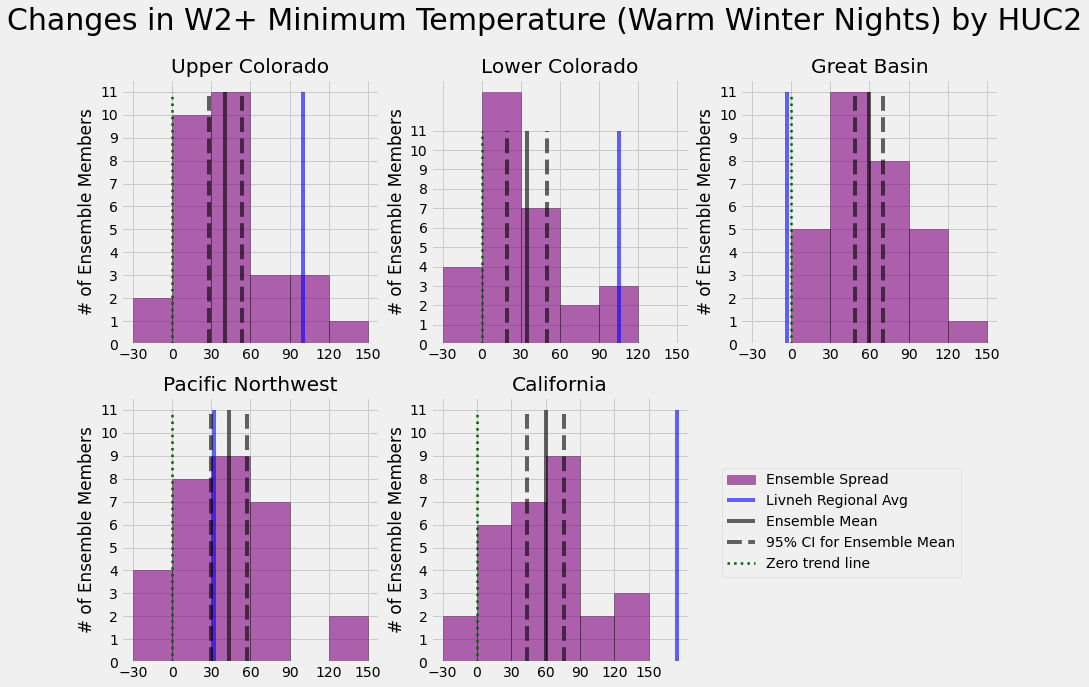

In [31]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(2,3, figsize=(14,10))
regions = list(ens_drought_spread.keys())
fax = ax.ravel()
bins = np.arange(-30,170, 30)
handles, labels = None, None
for ind, k in enumerate(regions):
    # get ensemble data and plot histogram
    regions_ens_spread = ens_drought_spread[k]
    fax[ind].hist(regions_ens_spread, bins = bins, edgecolor='black', label="Ensemble Spread", color="purple", alpha=0.6)
    
    # ticks and titles
    fax[ind].set_xticks(bins)
    fax[ind].set_yticks(np.arange(0,12))
    fax[ind].set_title(regions[ind])
    fax[ind].set_ylabel("# of Ensemble Members")
    
    # add line for livneh dataset and H&A average
    fax[ind].vlines(drought_change[k], ymin=0, ymax=11, color='blue',alpha=0.6, label =f"Livneh Regional Avg")
    
    # plot vlines for ensemble 5th and 95th percentiles
    ens_mean, ens_std = np.mean(regions_ens_spread), np.std(regions_ens_spread)
    fax[ind].vlines(ens_mean, color='black', alpha=0.6, linewidth=4, ymin=0, ymax=11, label="Ensemble Mean")
    
    percentiles = [ens_mean - 1.96*ens_std/(np.sqrt(len(regions_ens_spread))), 
                  ens_mean + 1.96*ens_std/(np.sqrt(len(regions_ens_spread)))]
    fax[ind].vlines(percentiles, color='black', alpha=0.6, 
                    linestyle="dashed", label="95% CI for Ensemble Mean", ymin=0, ymax=11, linewidth=4)
    # zero trend line
    fax[ind].vlines(0, color='darkgreen', label = "Zero trend line", ymin=0, ymax=11, 
                    linewidth=2.5, linestyle='dotted')
    
    percentiles = [ens_mean - 1.96*ens_std/(np.sqrt(len(regions_ens_spread))), 
                  ens_mean + 1.96*ens_std/(np.sqrt(len(regions_ens_spread)))]
    min_max = [np.min(regions_ens_spread), np.max(regions_ens_spread)]
    print(k, np.round(ens_mean), np.round(percentiles), np.round(min_max),np.round(drought_change[k]))


    
    # get handle labels for legend
    handles, labels = fax[ind].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.42, -0.15, 0.5, 0.5))#loc="lower right")
plt.suptitle("Changes in W2+ Minimum Temperature (Warm Winter Nights) by HUC2", fontsize=30)
fig.delaxes(ax[1,2])
plt.grid(True)
plt.savefig("/home/Julian.Schmitt/plots/TMIN_warm_winter_nights_ensemble_percentiles.png", dpi=250)

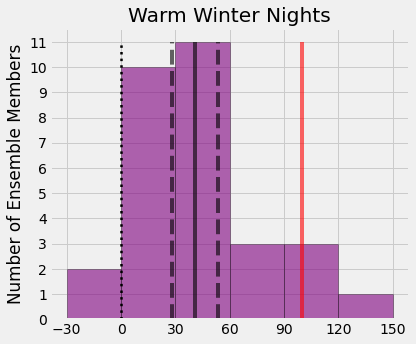

In [91]:
# single plot for UC
UC = ens_drought_spread[regions[0]]
bins = np.arange(-30,170, 30)
plt.figure(figsize=(6,5))
plt.hist(UC, bins = bins, edgecolor='black', label="Ensemble Spread", color="purple", alpha=0.6)
ymax = 11
# ticks and titles
plt.xticks(bins)
plt.yticks(np.arange(0,ymax+1))
plt.title("Warm Winter Nights")
plt.ylabel("Number of Ensemble Members")
#plt.xlabel("Percent Change in Warm Winter Nights")
# add line for livneh dataset and H&A average
plt.vlines(drought_change[regions[0]], ymin=0, ymax=ymax, color='red',alpha=0.6, label ="Livneh Regional Avg")
#fax[ind].vlines(30, ymin=0, ymax=11, color='green', alpha=0.6, label="H&A West Overall Average")

# plot vlines for ensemble 5th and 95th percentiles
ens_mean, ens_std = np.mean(UC), np.std(UC)
plt.vlines(ens_mean, color='black', alpha=0.6, linewidth=4, ymin=0, ymax=ymax, label="Ensemble Mean")

percentiles = [ens_mean - 1.96*ens_std/(np.sqrt(len(regions_ens_spread))), 
              ens_mean + 1.96*ens_std/(np.sqrt(len(regions_ens_spread)))]
plt.vlines(percentiles, color='black', alpha=0.6, 
                linestyle="dashed", label="95% CI for Ensemble Mean", ymin=0, ymax=ymax, linewidth=4)

# vertical line at zero for zero trend line
plt.vlines(0, color='black', label = "Zero trend line", ymin=0, ymax=ymax, linewidth=2.5, linestyle='dotted')
plt.tight_layout()
plt.savefig("/home/Julian.Schmitt/plots/UC_warm_nights.png", dpi=200)